In [3]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import collections
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# Configuration
DATASET_PATH = "DATASET_wiener" 
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 3
SEED = 42

In [5]:
# Step 1: Collect all image paths and labels
def get_image_paths_and_labels(dataset_path):
    class_names = sorted(entry.name for entry in os.scandir(dataset_path) if entry.is_dir())
    class_to_index = {name: idx for idx, name in enumerate(class_names)}

    image_paths = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(class_to_index[class_name])

    return image_paths, labels, class_names

all_paths, all_labels, class_names = get_image_paths_and_labels(DATASET_PATH)
num_classes = len(class_names)

In [6]:
# Step 2: Split into training, validation, and testing (80/10/10)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=SEED
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
)

In [7]:
# Step 3: Load images and preprocess
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def prepare_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(train_paths, train_labels)
val_ds = prepare_dataset(val_paths, val_labels)
test_ds = prepare_dataset(test_paths, test_labels)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

Train: 9261, Val: 1158, Test: 1158


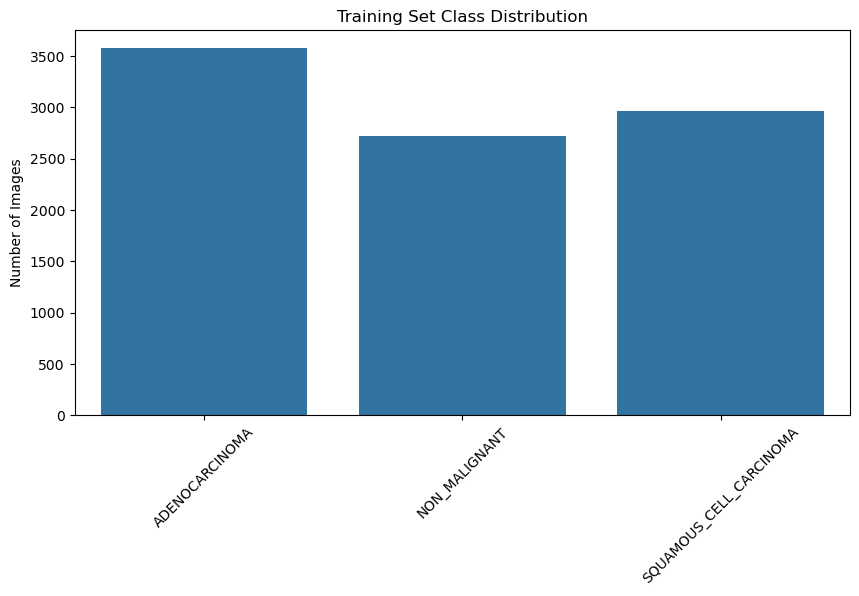

In [8]:
def plot_class_distribution(labels, class_names, title="Class Distribution"):
    counter = collections.Counter(labels)
    counts = [counter[i] for i in range(len(class_names))]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_names, y=counts)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

# Use on any split
plot_class_distribution(train_labels, class_names, title="Training Set Class Distribution")


In [ ]:
# Step 4: Define Model
def create_model(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ]) 
    return model

model = create_model(IMAGE_SIZE + (3,), num_classes)

In [10]:
# Assuming train_labels is a list or numpy array of labels for the training set
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to dict for Keras
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.863255033557047, 1: 1.1332599118942732, 2: 1.0425531914893618}


In [13]:
# Step 5: Compile and Train
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Perfect for integer labels
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)



Epoch 1/3
290/290 [==============================] - 67s 224ms/step - loss: 0.8077 - accuracy: 0.7431 - val_loss: 1.4614 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 2/3
290/290 [==============================] - 67s 230ms/step - loss: 0.5336 - accuracy: 0.8063 - val_loss: 4.9441 - val_accuracy: 0.3955 - lr: 0.0010
Epoch 3/3
290/290 [==============================] - 76s 262ms/step - loss: 0.5027 - accuracy: 0.8163 - val_loss: 0.6088 - val_accuracy: 0.8273 - lr: 0.0010


In [12]:
# Step 6: Plot Training Metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_metrics(history)

NameError: name 'history' is not defined

In [ ]:
# Step 7: Evaluate on Test Set
def evaluate_model(model, test_ds):
    results = model.evaluate(test_ds)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

evaluate_model(model, test_ds)


37/37 [==============================] - 9s 228ms/step - loss: 0.5176 - accuracy: 0.7651
Test Loss: 0.5176379680633545, Test Accuracy: 0.7651122808456421


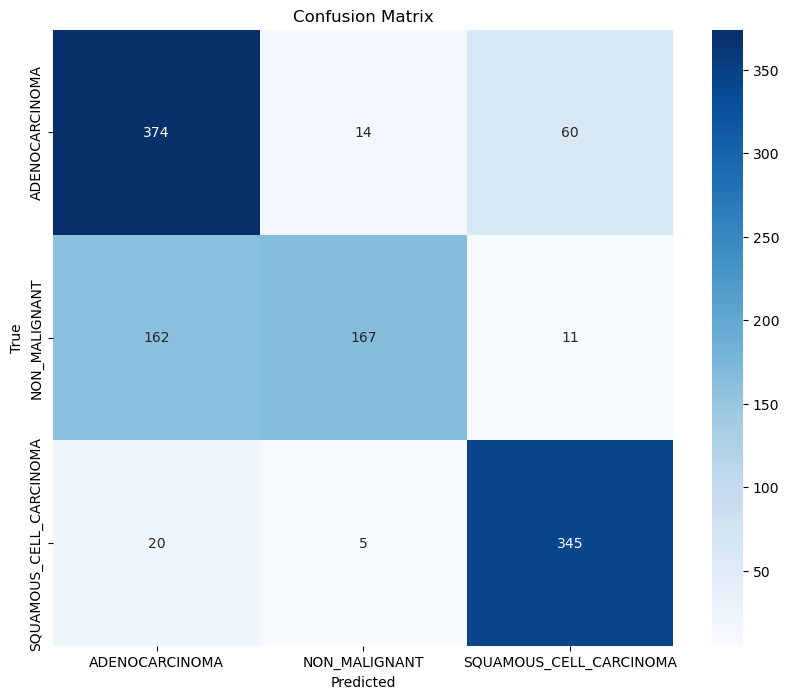

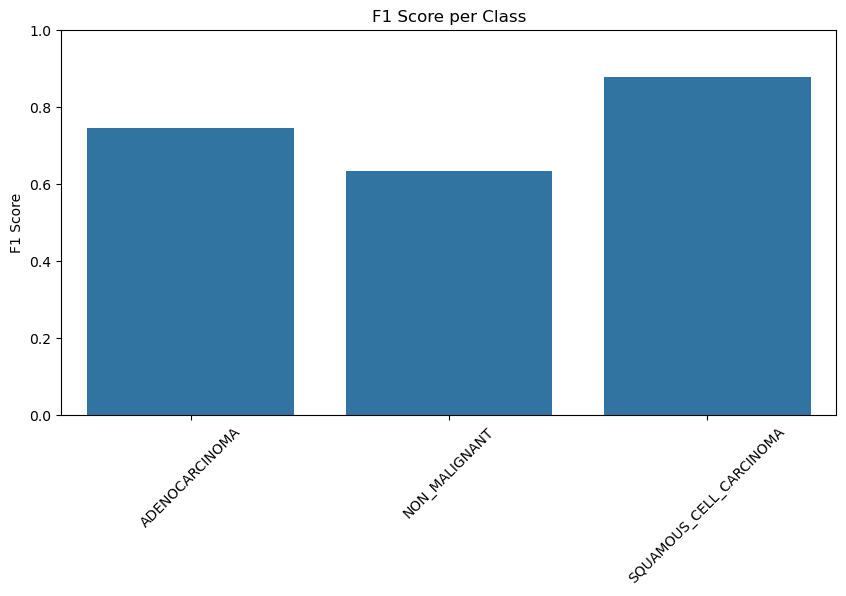

In [ ]:
# Step 8: Confusion Matrix and F1 Score
def get_predictions_and_labels(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions_and_labels(model, test_ds)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report (includes F1-score, precision, recall)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Plot F1-scores
f1_scores = [report[label]['f1-score'] for label in class_names]
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=f1_scores)
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Print full classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                         precision    recall  f1-score   support

         ADENOCARCINOMA       0.67      0.83      0.75       448
          NON_MALIGNANT       0.90      0.49      0.63       340
SQUAMOUS_CELL_CARCINOMA       0.83      0.93      0.88       370

               accuracy                           0.77      1158
              macro avg       0.80      0.75      0.75      1158
           weighted avg       0.79      0.77      0.76      1158



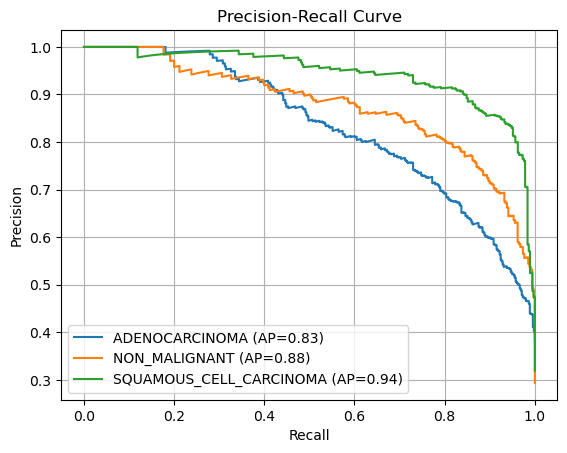

In [ ]:
# Convert to one-hot if multi-class
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
y_pred_prob = model.predict(test_ds, verbose=0)

# Compute and plot for each class
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{class_name} (AP={ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Get the predictions from the model (probabilities, not classes)
y_pred_prob = model.predict(test_ds)

# Get the true labels
y_true = []
for images, labels in test_ds:
    y_true.append(labels.numpy())

# Convert list of arrays to a single array
y_true = np.concatenate(y_true)

# For multi-class classification, we compute ROC AUC for each class
n_classes = len(class_names)  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC = 0.50)', color='gray')

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
